# [**Comparaison de `FeatureHasher` et `DictVectorizer`**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/text/plot_hashing_vs_dict_vectorizer.ipynb)<br/>([_FeatureHasher and DictVectorizer Comparison_](https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html))

Dans cet exemple, nous illustrons la vectorisation de texte, qui est le processus de représentation de données d'entrée non numériques (telles que des dictionnaires ou des documents textuels) sous forme de vecteurs de nombres réels.

Nous commençons par comparer les méthodes [**`FeatureHasher`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) et [**`DictVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) en utilisant ces deux méthodes pour vectoriser des documents textuels prétraités (tokenisés) à l'aide d'une fonction Python personnalisée.

Ensuite, nous introduisons et analysons les vectoriseurs spécifiques au texte [**`HashingVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html), [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) et [**`TfidfVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) qui gèrent à la fois la tokenisation et l'assemblage de la matrice de caractéristiques au sein d'une seule classe.

L'objectif de cet exemple est de démontrer l'utilisation de l'API de vectorisation de texte et de comparer leur temps de traitement. Consultez les scripts d'exemple [**Classification de documents textuels à l'aide de caractéristiques creuses**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/text/plot_document_classification_20newsgroups.ipynb) et [**Regroupement de documents textuels à l'aide de k-means**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/text/plot_document_clustering.ipynb) pour voir l'apprentissage réel sur des documents textuels.

In [ ]:
# Author: Lars Buitinck
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
# License: BSD 3 clause

# Chargement des données

Nous chargeons les données à partir de l'ensemble de données textuelles ["The 20 newsgroups"](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset), qui comprend environ 18 000 messages de groupes de discussion répartis sur 20 sujets, divisés en deux sous-ensembles : un pour l'entraînement et un pour les tests. Dans un souci de simplicité et de réduction des coûts de calcul, nous sélectionnons un sous-ensemble de 7 sujets et n'utilisons que l'ensemble d'entraînement.

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "misc.forsale",
    "rec.autos",
    "sci.space",
    "talk.religion.misc",
]

print("Loading 20 newsgroups training data")
raw_data, _ = fetch_20newsgroups(subset="train", categories=categories, return_X_y=True)
data_size_mb = sum(len(s.encode("utf-8")) for s in raw_data) / 1e6
print(f"{len(raw_data)} documents - {data_size_mb:.3f}MB")

Loading 20 newsgroups training data
3803 documents - 6.245MB


# Définition des fonctions de prétraitement

Un jeton peut être un mot, une partie d'un mot ou tout ce qui se trouve entre des espaces ou des symboles dans une chaîne de caractères. Ici, nous définissons une fonction qui extrait les jetons à l'aide d'une expression régulière simple (regex) qui correspond aux caractères de mots Unicode. Cela inclut la plupart des caractères pouvant faire partie d'un mot dans n'importe quelle langue, ainsi que les chiffres et le trait de soulignement :

In [2]:
import re


def tokenize(doc):
    """Extract tokens from doc.

    This uses a simple regex that matches word characters to break strings
    into tokens. For a more principled approach, see CountVectorizer or
    TfidfVectorizer.
    """
    return (tok.lower() for tok in re.findall(r"\w+", doc))


list(tokenize("This is a simple example, isn't it?"))

['this', 'is', 'a', 'simple', 'example', 'isn', 't', 'it']

Nous définissons une fonction supplémentaire qui compte la fréquence d'occurrence de chaque jeton dans un document donné. Elle renvoie un dictionnaire de fréquences à utiliser par les vectoriseurs.

In [3]:
from collections import defaultdict


def token_freqs(doc):
    """Extract a dict mapping tokens from doc to their occurrences."""

    freq = defaultdict(int)
    for tok in tokenize(doc):
        freq[tok] += 1
    return freq


token_freqs("That is one example, but this is another one")

defaultdict(int,
            {'that': 1,
             'is': 2,
             'one': 2,
             'example': 1,
             'but': 1,
             'this': 1,
             'another': 1})

Remarquez en particulier que le jeton répété `"is"` est compté deux fois, par exemple.

Le fait de découper un document textuel en jetons de mots, en perdant éventuellement les informations d'ordre entre les mots dans une phrase, est souvent appelé représentation [**"Bag of Words"** (_sac de mots_)](https://en.wikipedia.org/wiki/Bag-of-words_model).

# `DictVectorizer`

Tout d'abord, nous évaluons les performances de [**`DictVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html), puis nous le comparons à [**`FeatureHasher`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) car les deux reçoivent des dictionnaires en entrée.

In [4]:
from time import time
from sklearn.feature_extraction import DictVectorizer

dict_count_vectorizers = defaultdict(list)

t0 = time()
vectorizer = DictVectorizer()
vectorizer.fit_transform(token_freqs(d) for d in raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(
    vectorizer.__class__.__name__ + "\non freq dicts"
)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 1.256 s at 5.0 MB/s
Found 47928 unique terms


La correspondance réelle entre le jeton de texte et l'indice de colonne est explicitement stockée dans l'attribut `.vocabulary_`, qui est un dictionnaire Python potentiellement très volumineux :

In [5]:
type(vectorizer.vocabulary_)

dict

In [6]:
len(vectorizer.vocabulary_)

47928

In [7]:
vectorizer.vocabulary_["example"]

19145

# `FeatureHasher`

Les dictionnaires occupent beaucoup d'espace de stockage et augmentent en taille à mesure que l'ensemble d'entraînement grandit. Au lieu d'augmenter les vecteurs avec un dictionnaire, le "feature hashing" construit un vecteur de longueur prédéfinie en appliquant une fonction de hachage `h` aux caractéristiques (par exemple, les jetons), puis en utilisant directement les valeurs de hachage comme indices de caractéristiques et en mettant à jour le vecteur résultant à ces indices. Lorsque l'espace des caractéristiques n'est pas suffisamment grand, les fonctions de hachage ont tendance à mapper des valeurs distinctes sur le même code de hachage (collisions de hachage). Par conséquent, il est impossible de déterminer quel objet a généré un code de hachage particulier.

En raison de ce qui précède, il est impossible de récupérer les jetons d'origine à partir de la matrice de caractéristiques et la meilleure approche pour estimer le nombre de termes uniques dans le dictionnaire d'origine est de compter le nombre de colonnes actives dans la matrice de caractéristiques encodées. À cette fin, nous définissons la fonction suivante :

In [9]:
import numpy as np


def n_nonzero_columns(X):
    """Number of columns with at least one non-zero value in a CSR matrix.

    This is useful to count the number of features columns that are effectively
    active when using the FeatureHasher.
    """
    return len(np.unique(X.nonzero()[1]))

Le nombre par défaut de caractéristiques pour le [**`FeatureHasher`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) est $2^{20}$. Ici, nous définissons `n_features = 2**18` pour illustrer les collisions de hachage.

## `FeatureHasher` sur des dictionnaires de fréquence

In [10]:
from sklearn.feature_extraction import FeatureHasher

t0 = time()
hasher = FeatureHasher(n_features=2**18)
X = hasher.transform(token_freqs(d) for d in raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(
    hasher.__class__.__name__ + "\non freq dicts"
)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {n_nonzero_columns(X)} unique tokens")

done in 0.760 s at 8.2 MB/s
Found 43873 unique tokens


Le nombre de jetons uniques lors de l'utilisation de [**`FeatureHasher`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) est inférieur à ceux obtenus avec [**`DictVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html). Cela est dû aux collisions de hachage.

Le nombre de collisions peut être réduit en augmentant l'espace des caractéristiques. Remarquez que la vitesse du vectoriseur ne change pas de manière significative lorsqu'un grand nombre de caractéristiques est défini, bien que cela entraîne des dimensions de coefficient plus grandes et nécessite donc une utilisation plus importante de la mémoire pour les stocker, même si la majorité d'entre elles est inactive.

In [11]:
t0 = time()
hasher = FeatureHasher(n_features=2**22)
X = hasher.transform(token_freqs(d) for d in raw_data)
duration = time() - t0

print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {n_nonzero_columns(X)} unique tokens")

done in 0.757 s at 8.2 MB/s
Found 47668 unique tokens


Nous confirmons que le nombre de jetons uniques se rapproche du nombre de termes uniques trouvés par [**`DictVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html).

## `FeatureHasher` sur des jetons bruts

Alternativement, on peut définir `input_type="string"` dans [**`FeatureHasher`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) pour vectoriser directement les chaînes de caractères produites par la fonction de `tokenisation` personnalisée. Cela équivaut à passer un dictionnaire avec une fréquence implicite de 1 pour chaque nom de caractéristique.

In [12]:
t0 = time()
hasher = FeatureHasher(n_features=2**18, input_type="string")
X = hasher.transform(tokenize(d) for d in raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(
    hasher.__class__.__name__ + "\non raw tokens"
)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {n_nonzero_columns(X)} unique tokens")

done in 0.713 s at 8.8 MB/s
Found 43873 unique tokens


Nous traçons maintenant la vitesse des méthodes ci-dessus pour la vectorisation.

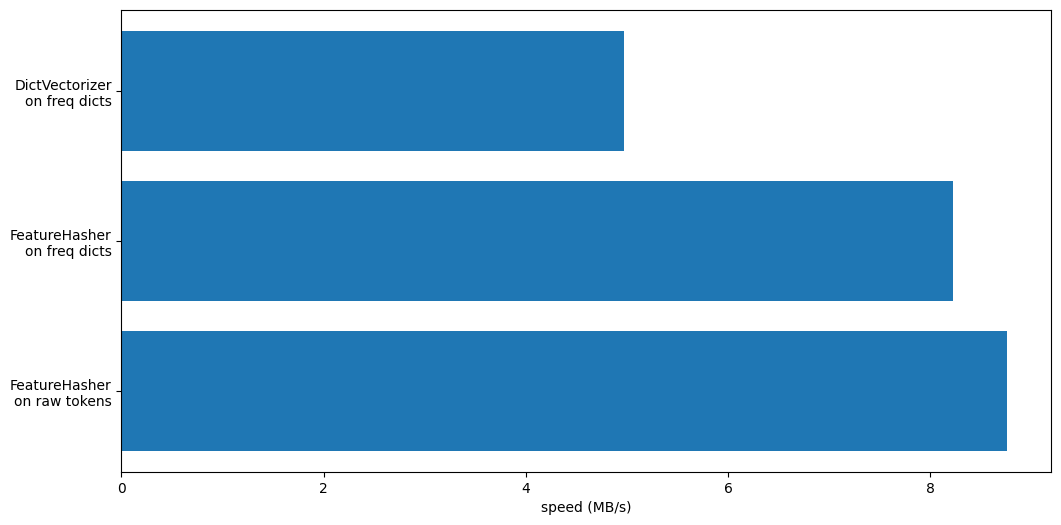

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

y_pos = np.arange(len(dict_count_vectorizers["vectorizer"]))
ax.barh(y_pos, dict_count_vectorizers["speed"], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(dict_count_vectorizers["vectorizer"])
ax.invert_yaxis()
_ = ax.set_xlabel("speed (MB/s)")

Dans les deux cas, [**`FeatureHasher`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) est environ deux fois plus rapide que [**`DictVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html). Cela est pratique lors du traitement de grandes quantités de données, avec l'inconvénient de perdre l'inversibilité de la transformation, ce qui rend l'interprétation d'un modèle plus complexe.

Le `FeatureHasher` avec `input_type="string"` est légèrement plus rapide que la variante qui fonctionne sur les dictionnaires de fréquence car il ne compte pas les jetons répétés : chaque jeton est implicitement compté une fois, même s'il est répété. Selon la tâche d'apprentissage automatique en aval, cela peut être une limitation ou non.

# Comparaison avec des vectoriseurs de texte spécialisés

[**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) accepte des données brutes car il implémente en interne la tokenisation et le comptage des occurrences. Il est similaire à [**`DictVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) lorsqu'il est utilisé avec la fonction personnalisée `token_freqs` comme dans la section précédente. La différence est que [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) est plus flexible. En particulier, il accepte différents modèles regex via le paramètre `token_pattern`.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

t0 = time()
vectorizer = CountVectorizer()
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 1.104 s at 5.7 MB/s
Found 47885 unique terms


Nous constatons que l'utilisation de l'implémentation [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) est environ deux fois plus rapide que l'utilisation de [**`DictVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) avec la fonction simple que nous avons définie pour mapper les jetons. La raison en est que [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) est optimisé en réutilisant une expression régulière compilée pour l'ensemble complet d'entraînement au lieu d'en créer une par document comme le fait notre fonction de tokenisation naïve.

Maintenant, nous faisons une expérience similaire avec [**`HashingVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html), qui équivaut à combiner le "hashing trick" implémenté par la classe [**`FeatureHasher`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) et la prétraitement et la tokenisation de [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [15]:
from sklearn.feature_extraction.text import HashingVectorizer

t0 = time()
vectorizer = HashingVectorizer(n_features=2**18)
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")

done in 0.882 s at 7.1 MB/s


Nous pouvons observer que c'est la stratégie de tokenisation de texte la plus rapide jusqu'à présent, en supposant que la tâche d'apprentissage automatique en aval peut tolérer quelques collisions.

## `TfidfVectorizer`

Dans un grand corpus de texte, certains mots apparaissent avec une fréquence plus élevée (par exemple, "the", "a", "is" en anglais) et ne portent pas d'informations significatives sur le contenu réel d'un document. Si nous devions fournir directement les données de comptage des mots à un classificateur, ces termes très courants masqueraient les fréquences des termes plus rares mais plus informatifs. Afin de rééquilibrer les caractéristiques de comptage en valeurs flottantes adaptées à une utilisation par un classificateur, il est très courant d'utiliser la transformation tf-idf telle qu'elle est implémentée par [**`TfidfTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). TF signifie "fréquence du terme" tandis que "tf-idf" signifie "fréquence du terme multipliée par la fréquence inverse dans les documents".

Nous évaluons maintenant [**`TfidfVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), qui équivaut à combiner la tokenisation et le comptage des occurrences de [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) avec la normalisation et la pondération d'un [**`TfidfTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

t0 = time()
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 0.959 s at 6.5 MB/s
Found 47885 unique terms


## Résumé

Concluons ce notebook en résumant toutes les vitesses de traitement enregistrées dans un seul graphique :

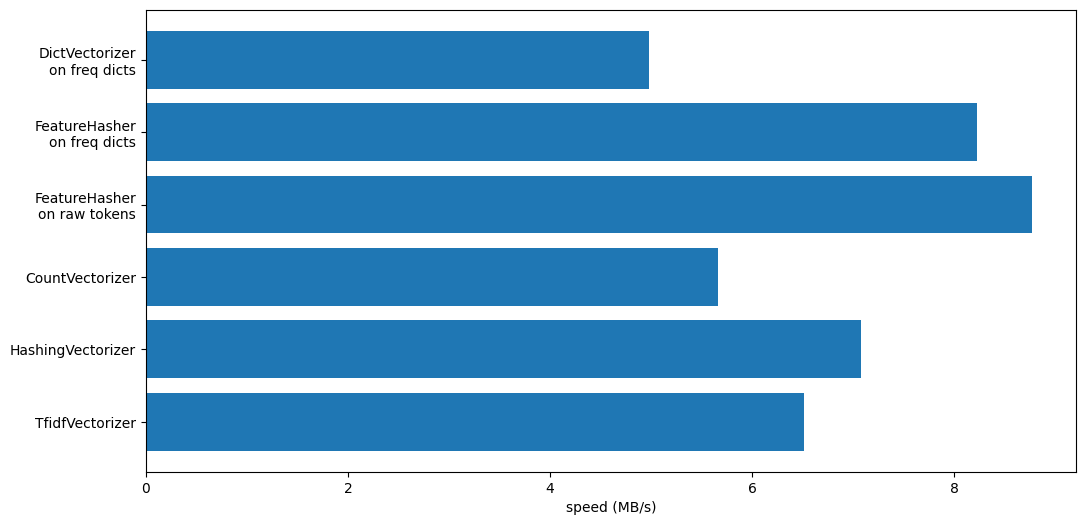

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

y_pos = np.arange(len(dict_count_vectorizers["vectorizer"]))
ax.barh(y_pos, dict_count_vectorizers["speed"], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(dict_count_vectorizers["vectorizer"])
ax.invert_yaxis()
_ = ax.set_xlabel("speed (MB/s)")

Remarquez sur le graphique que [**`TfidfVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) est légèrement plus lent que [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) en raison de l'opération supplémentaire induite par [**`TfidfTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

Remarquez également qu'en fixant le nombre de caractéristiques `n_features = 2**18`, [**`HashingVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) fonctionne mieux que [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) au détriment de l'inversibilité de la transformation en raison des collisions de hachage.

Nous soulignons que [**`CountVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) et [**`HashingVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) fonctionnent mieux que leur équivalent [**`DictVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) et [**`FeatureHasher`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) sur des documents tokenisés manuellement, car l'étape interne de tokenisation des premiers vectoriseurs compile une expression régulière une fois et la réutilise pour tous les documents.